# Project Customer Survey (By Oumar, Komlan)

In [33]:
from pyspark import SparkContext 
import pandas as pd
from pyspark.sql import SparkSession
spark = SparkSession(SparkContext.getOrCreate())

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import confusion_matrix
from pandas.plotting import scatter_matrix
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

## Data exploration

In [35]:
df = spark.read.csv("bank_customer_survey.csv", header = True, inferSchema = True)
df = df.withColumnRenamed("y", "label")
print(print((df.count(), len(df.columns))))
df.show(10)

(45211, 17)
None
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-----+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|label|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-----+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown|    0|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown|    0|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown|    0|
| 47|        blue| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown|    0|
| 33|     unknown|  single|  unknown|     no|      1

In [28]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- label: integer (nullable = true)



In [30]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

0                    1                    2      3       4
summary   count                 mean               stddev    min     max
age       45211    40.93621021432837   10.618762040975405     18      95
balance   45211   1362.2720576850766   3044.7658291685257  -8019  102127
day       45211    15.80641879188693    8.322476153044594      1      31
duration  45211    258.1630797814691    257.5278122651706      0    4918
campaign  45211    2.763840658246887    3.098020883279192      1      63
pdays     45211    40.19782796222158   100.12874599059828     -1     871
previous  45211   0.5803233726305546    2.303441044931218      0     275
label     45211  0.11698480458295547  0.32140573261566385      0       1

## Analyse des relations entre les variables

### 1. Relation entre les variables catégorielles

<AxesSubplot:xlabel='job', ylabel='count'>

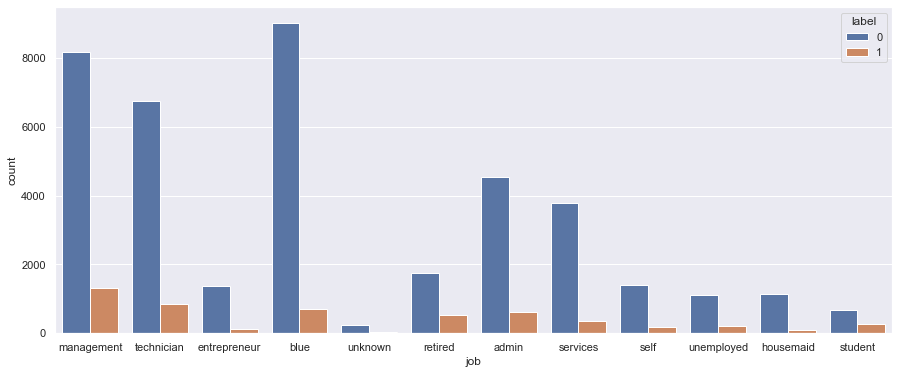

In [29]:
sns.set(rc = {'figure.figsize':(15,6)})
sns.countplot(x="job", hue="label", data=df.toPandas())

<AxesSubplot:xlabel='education', ylabel='count'>

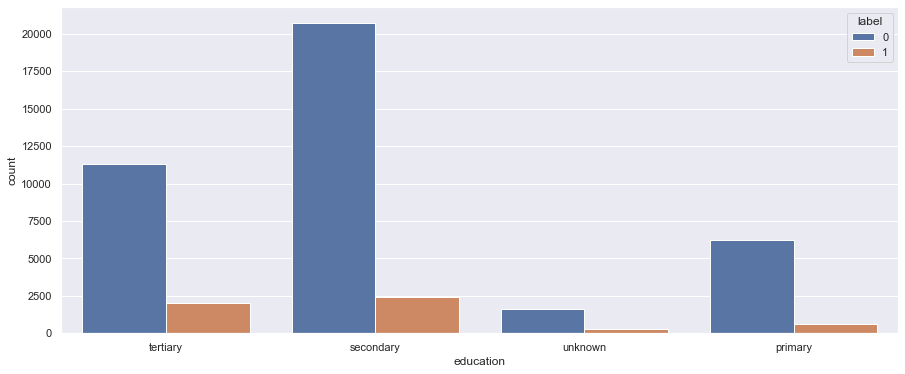

In [21]:
sns.countplot(x="education", hue="label", data=df.toPandas())

<AxesSubplot:xlabel='housing', ylabel='count'>

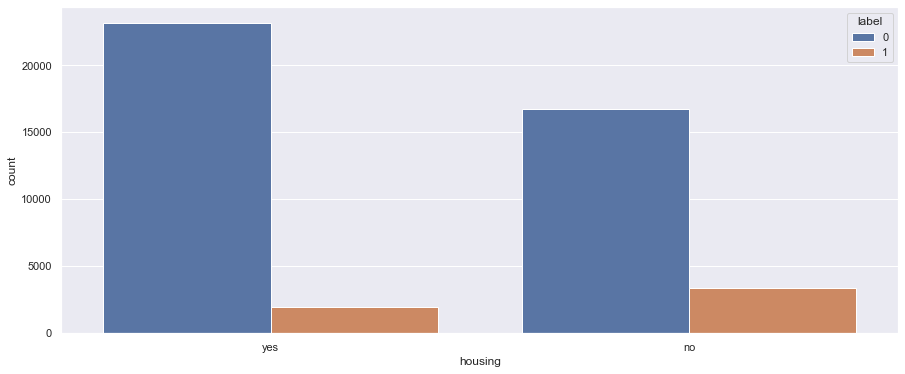

In [22]:
sns.countplot(x="housing", hue="label", data=df.toPandas())

### 2. Relation entre les variables numeriques

In [36]:
assembler = VectorAssembler(inputCols = numeric_features, outputCol = 'features')
num_data = assembler.transform(df).select('features')
num_data.show(10)

+--------------------+
|            features|
+--------------------+
|[58.0,2143.0,5.0,...|
|[44.0,29.0,5.0,15...|
|[33.0,2.0,5.0,76....|
|[47.0,1506.0,5.0,...|
|[33.0,1.0,5.0,198...|
|[35.0,231.0,5.0,1...|
|[28.0,447.0,5.0,2...|
|[42.0,2.0,5.0,380...|
|[58.0,121.0,5.0,5...|
|[43.0,593.0,5.0,5...|
+--------------------+
only showing top 10 rows



In [38]:
corr = Correlation.corr(num_data, 'features', 'pearson').collect()[0][0]
corr2 = corr.toArray()
corr2 = pd.DataFrame(corr2, columns=numeric_features, index = numeric_features)
corr2

/Users/komlan/pythonEnv/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


age   balance       day  duration  campaign     pdays  \
age       1.000000  0.097783 -0.009120 -0.004648  0.004760 -0.023758   
balance   0.097783  1.000000  0.004503  0.021560 -0.014578  0.003435   
day      -0.009120  0.004503  1.000000 -0.030206  0.162490 -0.093044   
duration -0.004648  0.021560 -0.030206  1.000000 -0.084570 -0.001565   
campaign  0.004760 -0.014578  0.162490 -0.084570  1.000000 -0.088628   
pdays    -0.023758  0.003435 -0.093044 -0.001565 -0.088628  1.000000   
previous  0.001288  0.016674 -0.051710  0.001203 -0.032855  0.454820   
label     0.025155  0.052838 -0.028348  0.394521 -0.073172  0.103621   

          previous     label  
age       0.001288  0.025155  
balance   0.016674  0.052838  
day      -0.051710 -0.028348  
duration  0.001203  0.394521  
campaign -0.032855 -0.073172  
pdays     0.454820  0.103621  
previous  1.000000  0.093236  
label     0.093236  1.000000

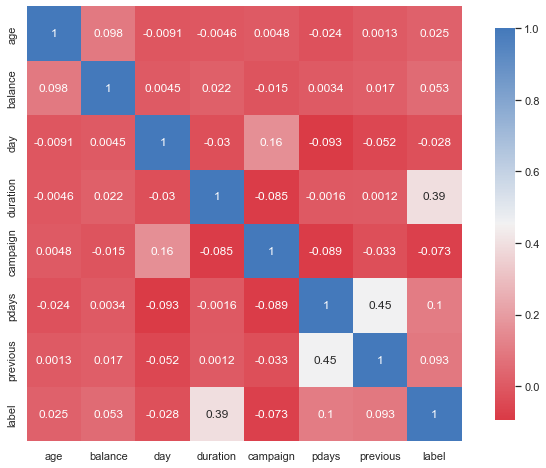

In [39]:
s , ax = plt.subplots(figsize =( 12 , 8))
cmap = sns.diverging_palette(10, 250  , as_cmap = True )
s = sns.heatmap(corr2, cmap = cmap, square=True,ax=ax, annot = True,cbar_kws={'shrink' : .9 }, annot_kws = {'fontsize':12})

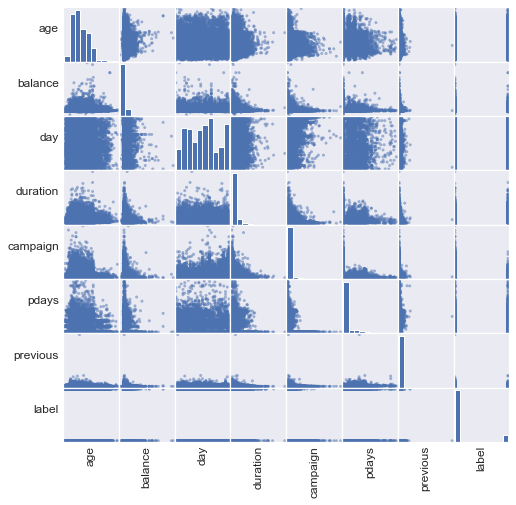

In [41]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8))
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [42]:
numeric_data

age  balance  day  duration  campaign  pdays  previous  label
0       58     2143    5       261         1     -1         0      0
1       44       29    5       151         1     -1         0      0
2       33        2    5        76         1     -1         0      0
3       47     1506    5        92         1     -1         0      0
4       33        1    5       198         1     -1         0      0
...    ...      ...  ...       ...       ...    ...       ...    ...
45206   51      825   17       977         3     -1         0      1
45207   71     1729   17       456         2     -1         0      1
45208   72     5715   17      1127         5    184         3      1
45209   57      668   17       508         4     -1         0      0
45210   37     2971   17       361         2    188        11      0

[45211 rows x 8 columns]

In [50]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'label')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- label: integer (nullable = true)



In [51]:
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

stages = []

for categoricalCol in categoricalColumns:
    
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    
    stages += [stringIndexer, encoder]

In [52]:
label_stringIdx = StringIndexer(inputCol = 'label', outputCol = 'class')

stages += [label_stringIdx]

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

stages += [assembler]

In [53]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['class', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()


root
 |-- class: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- label: integer (nullable = true)



In [54]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

22/03/04 18:02:29 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Training Dataset Count: 31716


Test Dataset Count: 13495


# Creating Logistic Regression Model



In [56]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'class', maxIter=10)
lrModel = lr.fit(train)


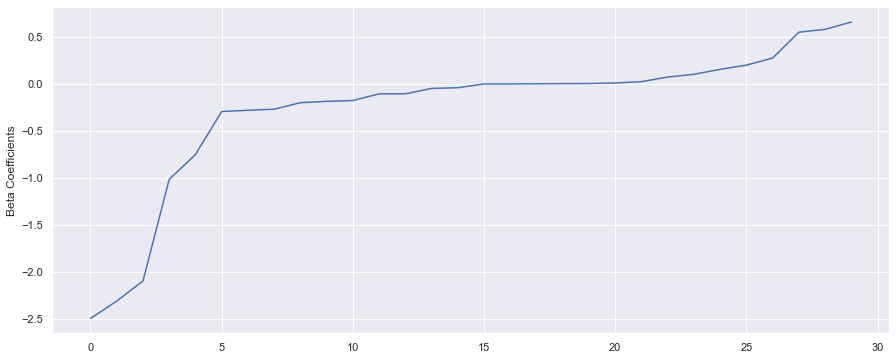

In [57]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

/Users/komlan/pythonEnv/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Training set areaUnderROC: 0.8893819685424522


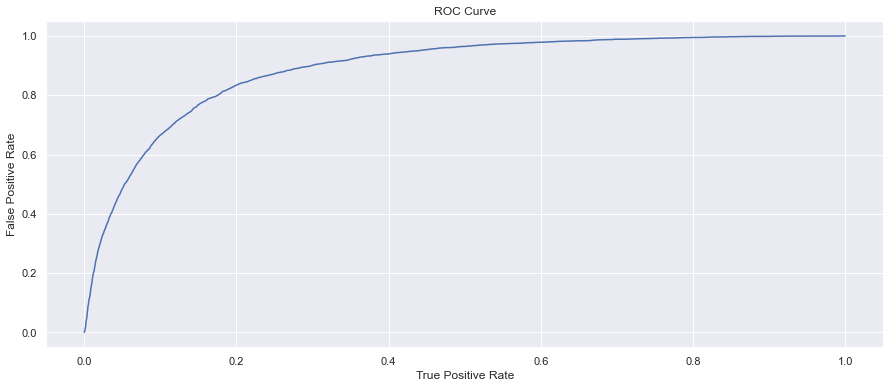

In [58]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig("precision_recall.png")
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

/Users/komlan/pythonEnv/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


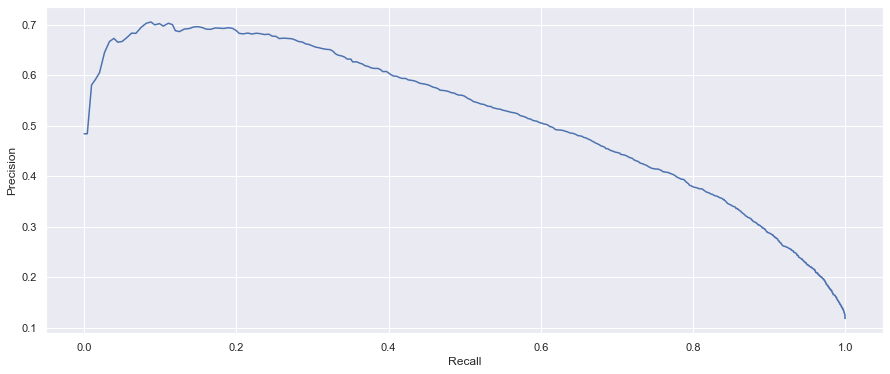

In [59]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [61]:
predictions = lrModel.transform(test)

predictions.select('age', 'job', 'class', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----+-----+--------------------+----------+--------------------+
|age| job|class|       rawPrediction|prediction|         probability|
+---+----+-----+--------------------+----------+--------------------+
| 24|blue|  0.0|[3.70038618690010...|       0.0|[0.97588206964663...|
| 26|blue|  0.0|[3.35922810707749...|       0.0|[0.96640572569520...|
| 26|blue|  0.0|[3.13807248724923...|       0.0|[0.95843616356727...|
| 26|blue|  0.0|[0.98479177264445...|       0.0|[0.72805797338141...|
| 27|blue|  0.0|[4.62265241584983...|       0.0|[0.99026892732556...|
| 28|blue|  0.0|[3.06394670619343...|       0.0|[0.95538084098277...|
| 28|blue|  0.0|[3.15379880374952...|       0.0|[0.95905814457810...|
| 28|blue|  0.0|[3.06317159677342...|       0.0|[0.95534778772874...|
| 28|blue|  0.0|[2.47175165699889...|       0.0|[0.92213762657030...|
| 28|blue|  0.0|[2.61145448494409...|       0.0|[0.93159514245437...|
+---+----+-----+--------------------+----------+--------------------+
only showing top 10 

In [62]:
print(predictions.select("class").collect()[0])

Row(class=0.0)


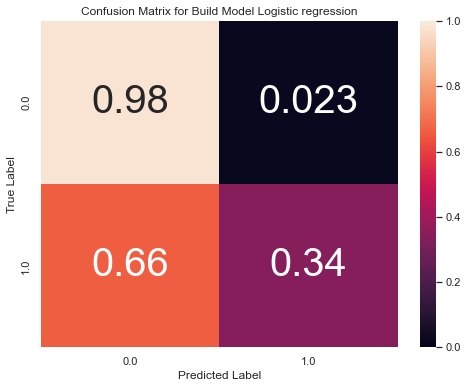

In [70]:
sns.set(rc = {'figure.figsize':(8,6)})
def plot_confusion_matrix(cm, classes=None, title=None, model=None):
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0, vmax=1, annot=True, annot_kws={'size':40})
    else:
        sns.heatmap(cm, vmin=0, vmax=1)
    plt.title(title+" "+model)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

y_pred = predictions.select("prediction").collect()
y_label = predictions.select("class").collect()

cm = confusion_matrix(y_label, y_pred)

cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
classes = np.unique(y_label)
plot_confusion_matrix(cm_norm, classes, title="Confusion Matrix for Build Model", model="Logistic regression")

In [71]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8953123002168385


# Decision Tree Classifier



In [65]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'class', maxDepth = 3)
dtModel = dt.fit(train)
predictions_dt = dtModel.transform(test)
predictions_dt.select('age', 'job', 'class', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----+-----+----------------+----------+--------------------+
|age| job|class|   rawPrediction|prediction|         probability|
+---+----+-----+----------------+----------+--------------------+
| 24|blue|  0.0|[25541.0,2061.0]|       0.0|[0.92533149771755...|
| 26|blue|  0.0|[25541.0,2061.0]|       0.0|[0.92533149771755...|
| 26|blue|  0.0|[25541.0,2061.0]|       0.0|[0.92533149771755...|
| 26|blue|  0.0|   [663.0,836.0]|       1.0|[0.44229486324216...|
| 27|blue|  0.0|[25541.0,2061.0]|       0.0|[0.92533149771755...|
| 28|blue|  0.0|[25541.0,2061.0]|       0.0|[0.92533149771755...|
| 28|blue|  0.0|[25541.0,2061.0]|       0.0|[0.92533149771755...|
| 28|blue|  0.0|[25541.0,2061.0]|       0.0|[0.92533149771755...|
| 28|blue|  0.0|[25541.0,2061.0]|       0.0|[0.92533149771755...|
| 28|blue|  0.0|[25541.0,2061.0]|       0.0|[0.92533149771755...|
+---+----+-----+----------------+----------+--------------------+
only showing top 10 rows



In [66]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_dt, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.31907009490637056


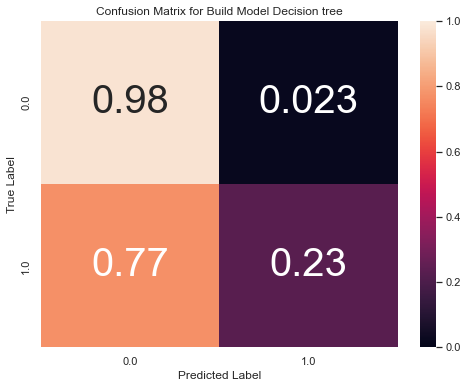

In [72]:
y_pred = predictions_dt.select("prediction").collect()
y_label = predictions_dt.select("class").collect()

cm = confusion_matrix(y_label, y_pred)

cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
classes = np.unique(y_label)
plot_confusion_matrix(cm_norm, classes, title="Confusion Matrix for Build Model", model="Decision tree")

# Random Forest Classifier



In [74]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'class')
rfModel = rf.fit(train)
predictions_rf = rfModel.transform(test)
predictions_rf.select('age', 'job', 'class', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----+-----+--------------------+----------+--------------------+
|age| job|class|       rawPrediction|prediction|         probability|
+---+----+-----+--------------------+----------+--------------------+
| 24|blue|  0.0|[18.4220771017551...|       0.0|[0.92110385508775...|
| 26|blue|  0.0|[18.4281860428594...|       0.0|[0.92140930214297...|
| 26|blue|  0.0|[18.4281860428594...|       0.0|[0.92140930214297...|
| 26|blue|  0.0|[15.6588858818590...|       0.0|[0.78294429409295...|
| 27|blue|  0.0|[18.4281860428594...|       0.0|[0.92140930214297...|
| 28|blue|  0.0|[18.4281860428594...|       0.0|[0.92140930214297...|
| 28|blue|  0.0|[18.4220771017551...|       0.0|[0.92110385508775...|
| 28|blue|  0.0|[18.4326532123065...|       0.0|[0.92163266061532...|
| 28|blue|  0.0|[18.4353496506307...|       0.0|[0.92176748253153...|
| 28|blue|  0.0|[18.4326532123065...|       0.0|[0.92163266061532...|
+---+----+-----+--------------------+----------+--------------------+
only showing top 10 

In [75]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8953123002168385


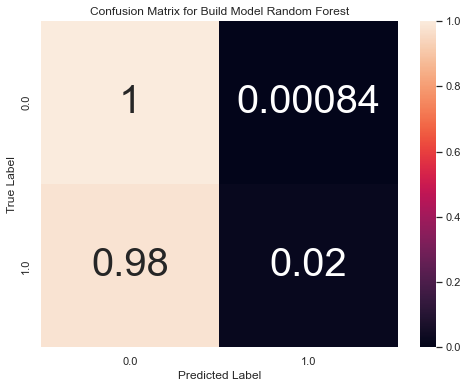

In [76]:
y_pred = predictions_rf.select("prediction").collect()
y_label = predictions_rf.select("class").collect()

cm = confusion_matrix(y_label, y_pred)

cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
classes = np.unique(y_label)
plot_confusion_matrix(cm_norm, classes, title="Confusion Matrix for Build Model", model="Random Forest")

# Gradient-Boosted Tree Classifier



In [77]:
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions_gb = gbtModel.transform(test)
predictions_gb.select('age', 'job', 'class', 'rawPrediction', 'prediction', 'probability').show(10)


+---+----+-----+--------------------+----------+--------------------+
|age| job|class|       rawPrediction|prediction|         probability|
+---+----+-----+--------------------+----------+--------------------+
| 24|blue|  0.0|[1.17196662570680...|       0.0|[0.91245080050113...|
| 26|blue|  0.0|[1.03011439273771...|       0.0|[0.88697710740927...|
| 26|blue|  0.0|[1.03011439273771...|       0.0|[0.88697710740927...|
| 26|blue|  0.0|[0.21848829150808...|       0.0|[0.60753837567100...|
| 27|blue|  0.0|[1.31958695133933...|       0.0|[0.93334058640199...|
| 28|blue|  0.0|[1.03011439273771...|       0.0|[0.88697710740927...|
| 28|blue|  0.0|[1.00896043268053...|       0.0|[0.88266585096652...|
| 28|blue|  0.0|[1.00896043268053...|       0.0|[0.88266585096652...|
| 28|blue|  0.0|[0.96620856540222...|       0.0|[0.87351671840316...|
| 28|blue|  0.0|[1.00470270670296...|       0.0|[0.88178105463441...|
+---+----+-----+--------------------+----------+--------------------+
only showing top 10 

In [78]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8953123002168385


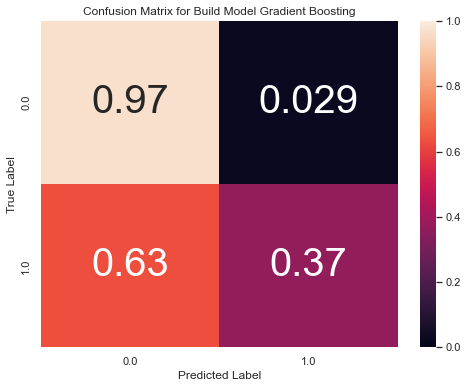

In [80]:
y_pred = predictions_gb.select("prediction").collect()
y_label = predictions_gb.select("class").collect()

cm = confusion_matrix(y_label, y_pred)

cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
classes = np.unique(y_label)
plot_confusion_matrix(cm_norm, classes, title="Confusion Matrix for Build Model", model="Gradient Boosting")

# Linear Support Vector Machine


In [81]:
lsvc = LinearSVC(maxIter=10, regParam=0.1)

# Fit the model
lsvcModel = lsvc.fit(train)

# Print the coefficients and intercept for linearsSVC
print("Coefficients: " + str(lsvcModel.coefficients))
print("Intercept: " + str(lsvcModel.intercept))

Coefficients: [-0.012602874801917192,0.0020956546410919982,0.005201289329219625,0.01971942247361287,0.01869444722545187,0.022118035826054233,-0.00017380305191347747,-0.015915744726216735,0.003216934942619754,-0.023033663424606575,0.05775986133171181,-0.005383102983763748,0.002859362972033549,-0.01772557394538835,0.008138858947710988,-0.01550108158315846,0.042387527759952824,-0.050173097908114424,0.04259226567114565,-0.0,-0.12978842608454233,-0.3170658222298964,-0.3602447994762481,-0.3517795715288839,0.0006346803279004707,9.829938476057113e-07,0.00033297561025221573,-0.00909429409389848,0.00027905713615209945,6.59452675236113e-05]
Intercept: -0.8787616405017249


In [82]:
predictions_svm = lsvcModel.transform(test)
predictions_svm.select('age', 'job', 'class', 'rawPrediction', 'prediction').show(10)


+---+----+-----+--------------------+----------+
|age| job|class|       rawPrediction|prediction|
+---+----+-----+--------------------+----------+
| 24|blue|  0.0|[1.16112179602391...|       0.0|
| 26|blue|  0.0|[1.13281973112686...|       0.0|
| 26|blue|  0.0|[1.11377029963265...|       0.0|
| 26|blue|  0.0|[0.93387278993171...|       0.0|
| 27|blue|  0.0|[1.23932578958779...|       0.0|
| 28|blue|  0.0|[1.10632262937145...|       0.0|
| 28|blue|  0.0|[1.11366649580269...|       0.0|
| 28|blue|  0.0|[1.10645205645943...|       0.0|
| 28|blue|  0.0|[1.05743237916663...|       0.0|
| 28|blue|  0.0|[1.06890858906571...|       0.0|
+---+----+-----+--------------------+----------+
only showing top 10 rows



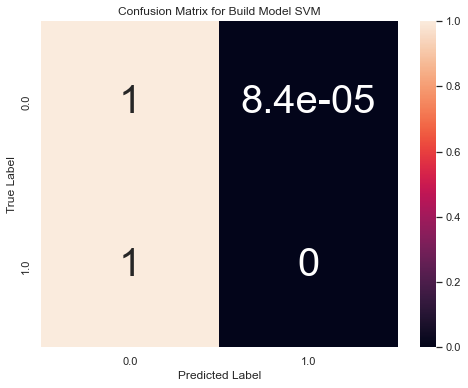

In [83]:
y_pred = predictions_svm.select("prediction").collect()
y_label = predictions_svm.select("class").collect()

cm = confusion_matrix(y_label, y_pred)

cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
classes = np.unique(y_label)
plot_confusion_matrix(cm_norm, classes, title="Confusion Matrix for Build Model", model="SVM")